# 小组作业
要求： 在本notebook基础上提升模型在验证集的准确率，并在最后说明实现思路

In [1]:
# 导入基础库
import torch                    # PyTorch核心库
import torch.nn as nn          # 神经网络模块
import torch.optim as optim    # 优化器模块
import torch.nn.functional as F # 函数式接口

# 导入数据处理库
import torchvision                          # 计算机视觉工具包
import torchvision.transforms as transforms # 数据变换工具
from torch.utils.data import DataLoader    # 数据加载器

# 导入其他工具库
import numpy as np              # 数值计算
import matplotlib.pyplot as plt # 绘图
import time                     # 时间工具
import random                   # 随机数
from sklearn.metrics import confusion_matrix  # 混淆矩阵

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 所有库导入成功！")


✅ 所有库导入成功！


In [2]:
#根据版本选择选择设备代码
if torch.cuda.is_available():
    print(f"🚀 GPU可用: {torch.cuda.get_device_name(0)}")
    print(f"📊 GPU显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    device = torch.device("cuda")
else:
    print("💻 使用CPU运算")
    device = torch.device("cpu")

# if torch.accelerator.is_available():
#     tensor = tensor.to(torch.accelerator.current_accelerator())

🚀 GPU可用: NVIDIA GeForce RTX 3060 Laptop GPU
📊 GPU显存: 6.0 GB


In [3]:

class CIFAR10_CNN(nn.Module):
    """
    用于CIFAR-10分类的CNN模型
    """
    def __init__(self, num_classes=10):
        super(CIFAR10_CNN, self).__init__()
        
        # 特征提取部分
        self.features = nn.Sequential(
            # 第一个卷积块
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # 32x32x32
            nn.BatchNorm2d(32),                             # 批归一化
            nn.ReLU(inplace=True),                          # 原地激活
            nn.Conv2d(32, 32, kernel_size=3, padding=1),    # 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),          # 16x16x32
            nn.Dropout2d(0.25),                             # Dropout防过拟合
            
            # 第二个卷积块
            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),    # 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),          # 8x8x64
            nn.Dropout2d(0.25),
            
            # 第三个卷积块
            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),          # 4x4x128
            nn.Dropout2d(0.25),
        )
        
        # 分类器部分
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),                   # 全连接层
            nn.BatchNorm1d(512),                           # 1D批归一化
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),                               # 1D Dropout
            nn.Linear(512, num_classes)                    # 输出层
        )
    
    def forward(self, x):
        x = self.features(x)                             # 特征提取
        x = x.view(x.size(0), -1)                       # 展平：[batch, 128*4*4]
        x = self.classifier(x)                           # 分类
        return x

# 创建模型并查看结构
model = CIFAR10_CNN(num_classes=10)
print("=== CIFAR-10 CNN模型 ===")
print(model)

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n总参数数量: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")


=== CIFAR-10 CNN模型 ===
CIFAR10_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride

In [4]:
# 3.2.1 加载CIFAR-10数据集
print("=== 加载CIFAR-10数据集 ===")

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# 数据预处理管道
# 训练时的数据增强
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),     # 50%概率水平翻转
    transforms.RandomRotation(10),              # 随机旋转±10度
    transforms.ToTensor(),                      # 转换为张量[0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 标准化
])

# 测试时只做基本预处理
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 下载和加载数据集
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform
)

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 创建数据加载器
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")


=== 加载CIFAR-10数据集 ===
Files already downloaded and verified
Files already downloaded and verified
训练集大小: 50000
测试集大小: 10000
训练批次数: 391
测试批次数: 79


=== CIFAR-10 数据丰富可视化 ===
1️⃣ 随机样本展示


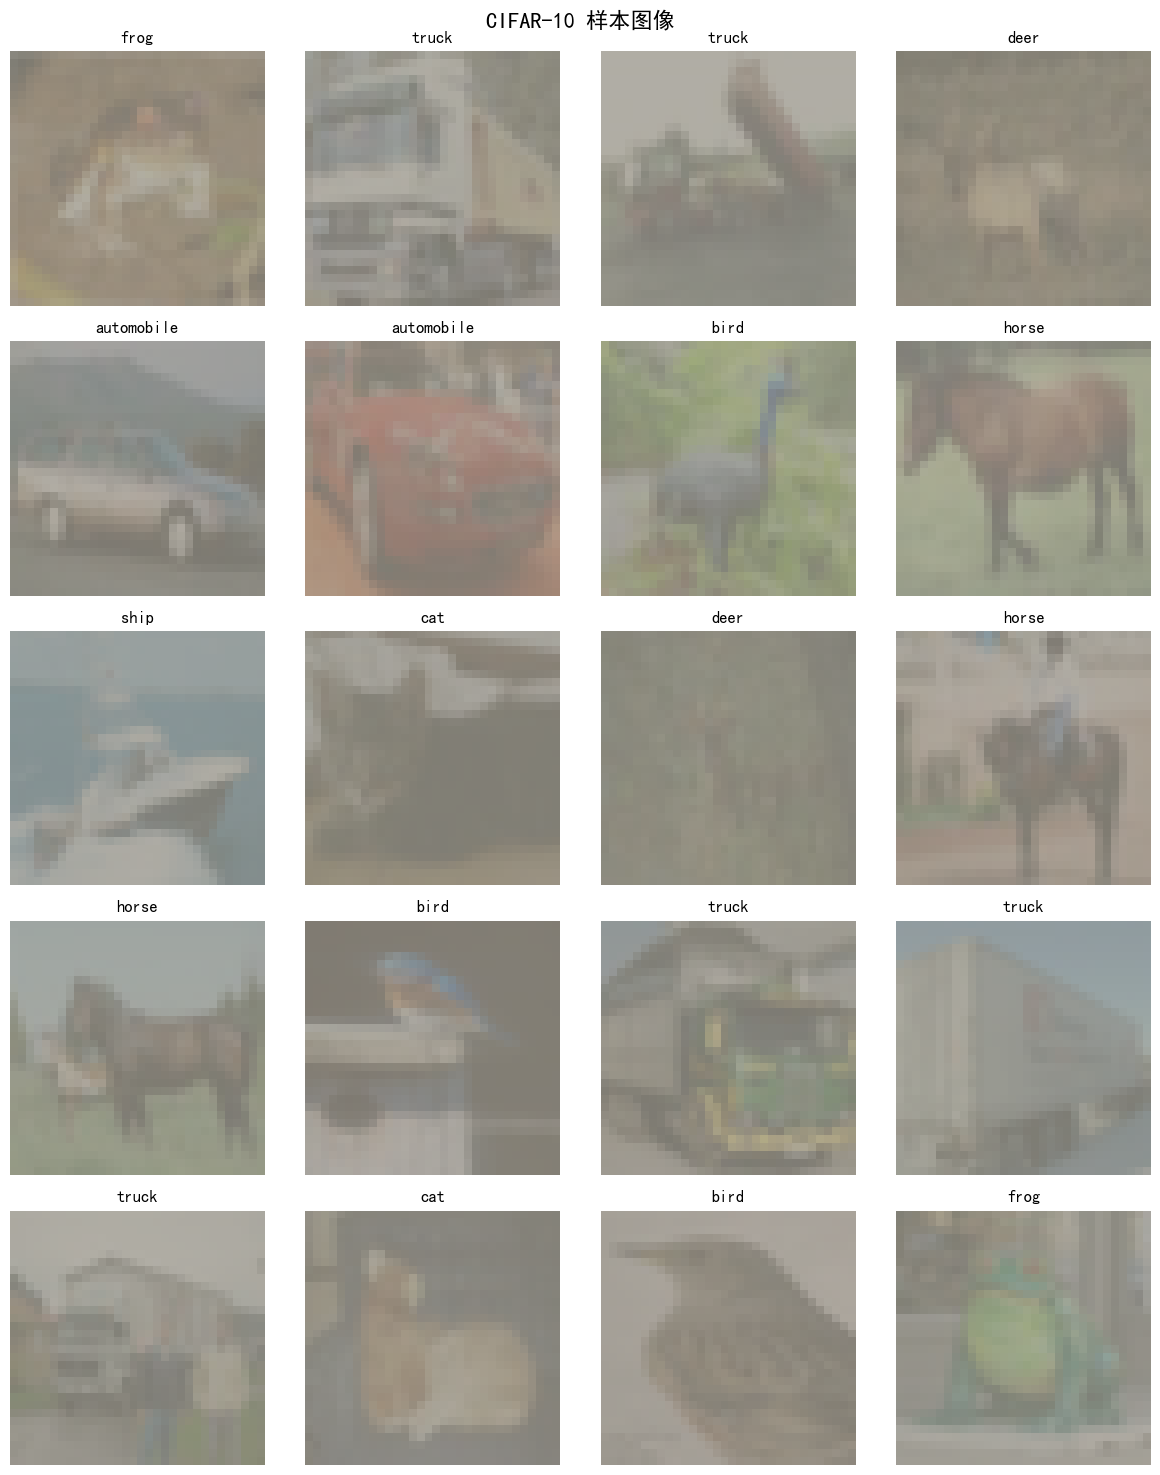


2️⃣ 各类别样本展示
=== 每个类别的样本展示 ===


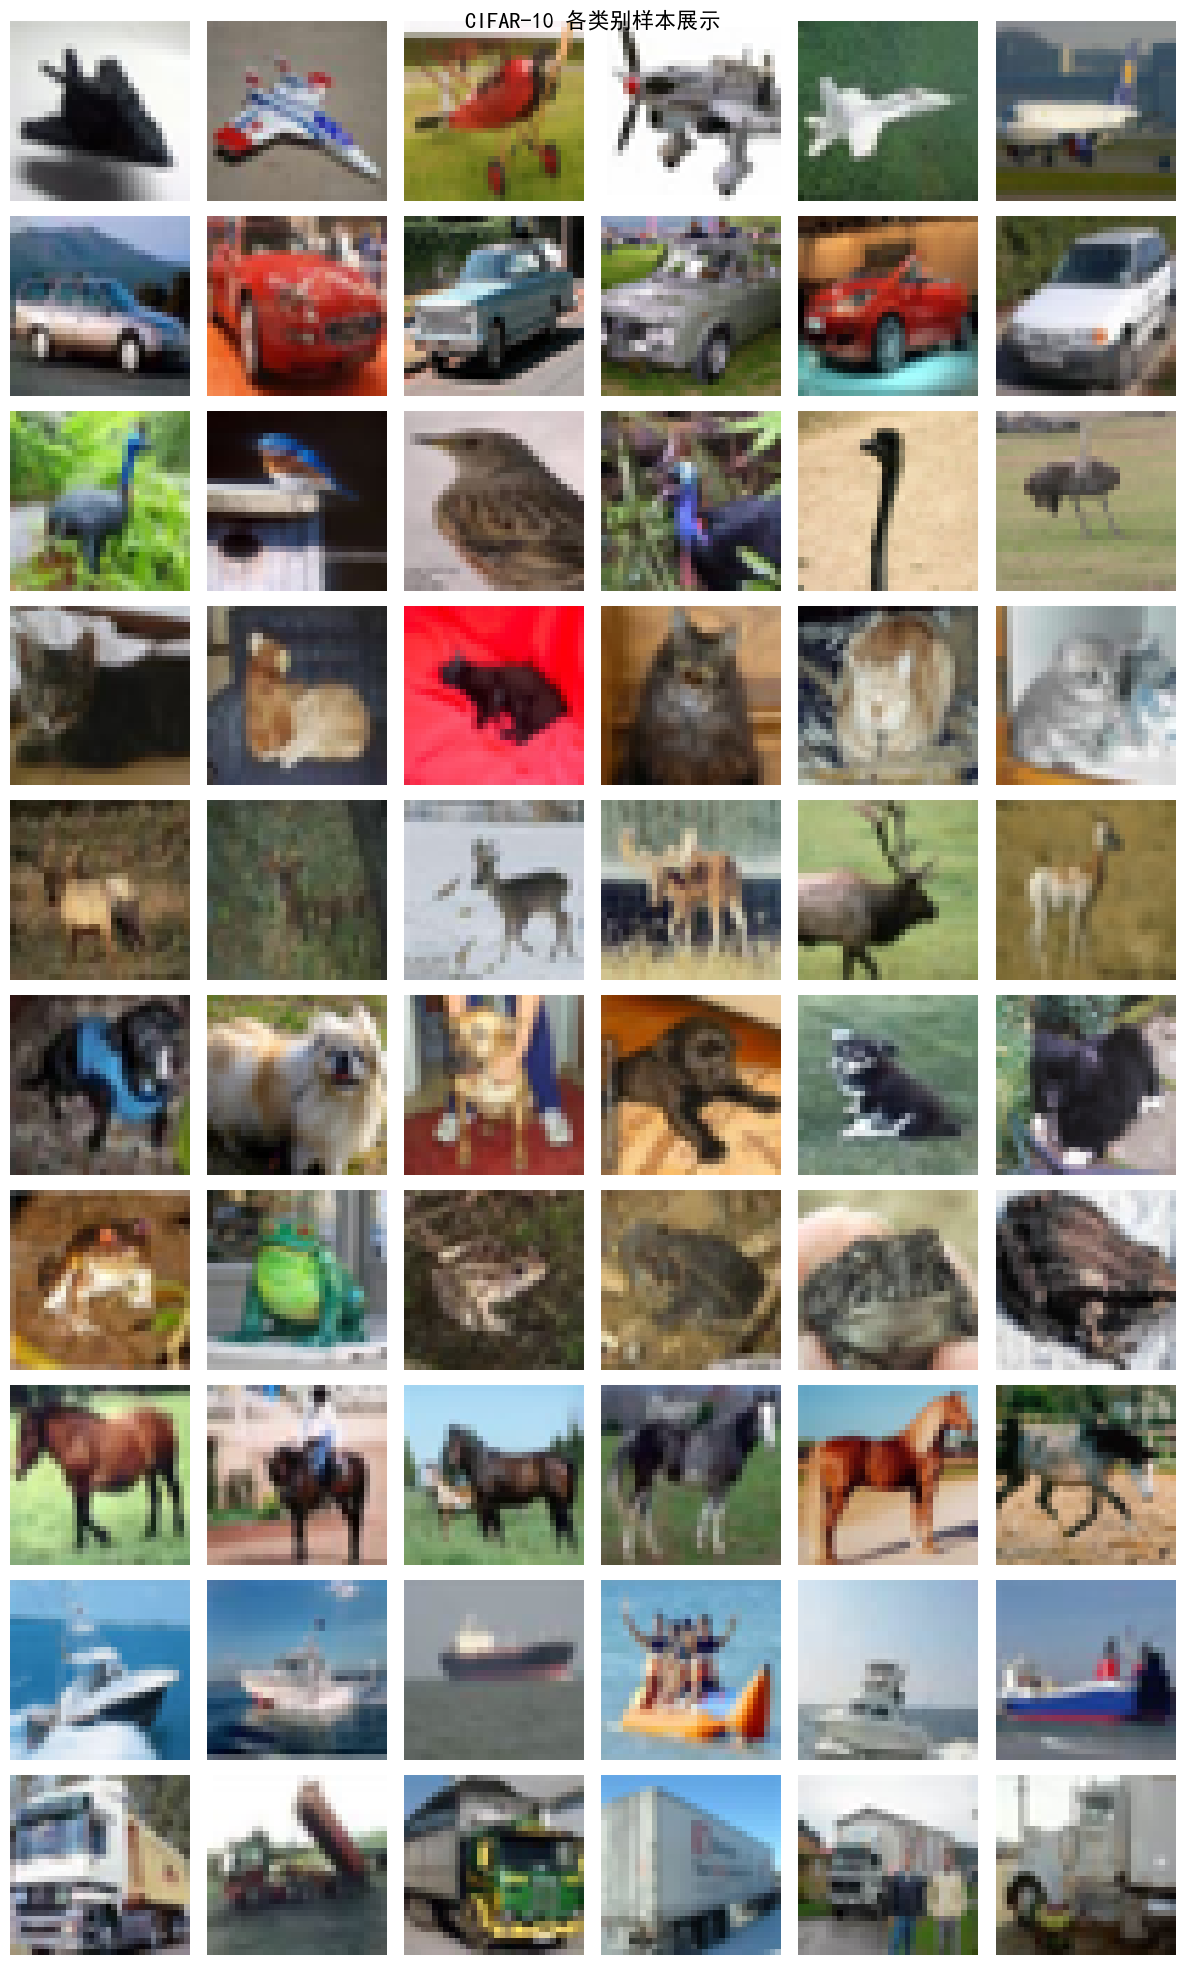

In [5]:
# 3.2.2 数据丰富可视化展示
def show_images(dataset, num_images=8):
    """显示数据集中的图像"""
    rows = (num_images + 3) // 4  # 动态计算行数
    fig, axes = plt.subplots(rows, 4, figsize=(12, 3*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)  # 确保axes是二维的
    fig.suptitle('CIFAR-10 样本图像', fontsize=16)
    
    for i in range(num_images):
        image, label = dataset[i]
        
        # 如果图像已经标准化，需要反标准化来显示
        if isinstance(image, torch.Tensor):
            # 反标准化
            mean = torch.tensor([0.4914, 0.4822, 0.4465])
            std = torch.tensor([0.2023, 0.1994, 0.2010])
            image = image * std.view(3, 1, 1) + mean.view(3, 1, 1)
            image = torch.clamp(image, 0, 1)  # 确保在[0,1]范围内
            
            # 转换为可显示的格式
            image = image.permute(1, 2, 0)   # CHW -> HWC
        
        row, col = i // 4, i % 4
        axes[row, col].imshow(image)
        axes[row, col].set_title(f'{class_names[label]}')
        axes[row, col].axis('off')
    
    # 隐藏多余的子图
    for i in range(num_images, rows * 4):
        row, col = i // 4, i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def show_class_samples(dataset, class_names, samples_per_class=5):
    """显示每个类别的样本图像"""
    print("=== 每个类别的样本展示 ===")
    
    # 收集每个类别的样本索引
    class_samples = {i: [] for i in range(len(class_names))}
    for idx, (_, label) in enumerate(dataset):
        if len(class_samples[label]) < samples_per_class:
            class_samples[label].append(idx)
        if all(len(samples) >= samples_per_class for samples in class_samples.values()):
            break
    
    # 创建大图显示所有类别
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                            figsize=(samples_per_class*2, len(class_names)*2))
    fig.suptitle('CIFAR-10 各类别样本展示', fontsize=16)
    
    for class_idx, class_name in enumerate(class_names):
        for sample_idx in range(samples_per_class):
            if sample_idx < len(class_samples[class_idx]):
                image, label = dataset[class_samples[class_idx][sample_idx]]
                
                # 处理图像显示
                if isinstance(image, torch.Tensor):
                    image = image.permute(1, 2, 0)  # CHW -> HWC
                
                axes[class_idx, sample_idx].imshow(image)
                if sample_idx == 0:  # 只在第一列显示类别名
                    axes[class_idx, sample_idx].set_ylabel(f'{class_idx}. {class_name}', 
                                                          fontsize=12, rotation=0, 
                                                          ha='right', va='center')
                axes[class_idx, sample_idx].axis('off')
            else:
                axes[class_idx, sample_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print("=== CIFAR-10 数据丰富可视化 ===")

# 创建一个不做数据增强的数据集用于可视化
viz_transform = transforms.Compose([
    transforms.ToTensor()  # 只转换为张量，不做标准化
])

viz_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    transform=viz_transform
)

# 1. 显示随机样本图像（增加到20张）
print("1️⃣ 随机样本展示")
show_images(viz_dataset, num_images=20)

# 2. 显示每个类别的样本
print("\n2️⃣ 各类别样本展示")
show_class_samples(viz_dataset, class_names, samples_per_class=6)


In [6]:
# 3.3.1 定义训练和评估函数
def train_epoch(model, train_loader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()                            # 设置为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # 移动数据到设备
        data, target = data.to(device), target.to(device)
        
        # 前向传播
        optimizer.zero_grad()                # 清零梯度
        output = model(data)                 # 前向传播
        loss = criterion(output, target)     # 计算损失
        
        # 反向传播
        loss.backward()                      # 计算梯度
        
        # 梯度裁剪（防止梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()                     # 更新参数
        
        # 统计
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # 每100个batch打印一次进度
        if batch_idx % 100 == 0:
            print(f'训练进度: [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\\t'
                  f'损失: {loss.item():.6f}')
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    """评估模型"""
    model.eval()                             # 设置为评估模式
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():                    # 评估时不需要计算梯度
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            # 获取预测结果
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("=== 训练和评估函数定义完成 ===")


=== 训练和评估函数定义完成 ===


In [7]:
# 3.3.2 完整的训练循环
print("=== 开始训练CIFAR-10分类模型 ===")

# 重新创建模型（确保参数随机初始化）
model = CIFAR10_CNN(num_classes=10).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()               # 交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adam优化器 + L2正则化

# 学习率调度器 - 每7个epoch学习率乘以0.5
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

# 训练参数
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"开始训练，共{num_epochs}个epoch")
print(f"使用设备: {device}")
print("-" * 60)

# 训练循环
for epoch in range(num_epochs):
    start_time = time.time()
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 评估
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # 更新学习率
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录结果
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # 计算时间
    epoch_time = time.time() - start_time
    
    # 打印结果
    print(f'Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.2f}s')
    print(f'训练: 损失={train_loss:.4f}, 准确率={train_acc:.2f}%')
    print(f'测试: 损失={test_loss:.4f}, 准确率={test_acc:.2f}%')
    print(f'学习率: {current_lr:.6f}')
    print("-" * 60)

print("训练完成！")
print(f"最终测试准确率: {test_accuracies[-1]:.2f}%")


=== 开始训练CIFAR-10分类模型 ===
开始训练，共10个epoch
使用设备: cuda
------------------------------------------------------------
训练进度: [0/50000 (0%)]\t损失: 2.457700
训练进度: [12800/50000 (26%)]\t损失: 1.691307
训练进度: [25600/50000 (51%)]\t损失: 1.437663
训练进度: [38400/50000 (77%)]\t损失: 1.300128
Epoch [1/10] - 22.61s
训练: 损失=1.5566, 准确率=43.21%
测试: 损失=1.1435, 准确率=58.66%
学习率: 0.001000
------------------------------------------------------------
训练进度: [0/50000 (0%)]\t损失: 1.247497
训练进度: [12800/50000 (26%)]\t损失: 1.432621
训练进度: [25600/50000 (51%)]\t损失: 1.125263
训练进度: [38400/50000 (77%)]\t损失: 1.155820
Epoch [2/10] - 18.45s
训练: 损失=1.1840, 准确率=57.84%
测试: 损失=0.9154, 准确率=67.35%
学习率: 0.001000
------------------------------------------------------------
训练进度: [0/50000 (0%)]\t损失: 1.108405
训练进度: [12800/50000 (26%)]\t损失: 1.185620
训练进度: [25600/50000 (51%)]\t损失: 0.969216
训练进度: [38400/50000 (77%)]\t损失: 0.944448
Epoch [3/10] - 18.65s
训练: 损失=1.0255, 准确率=63.64%
测试: 损失=0.8118, 准确率=71.42%
学习率: 0.001000
-------------------------------------

=== 训练结果可视化 ===


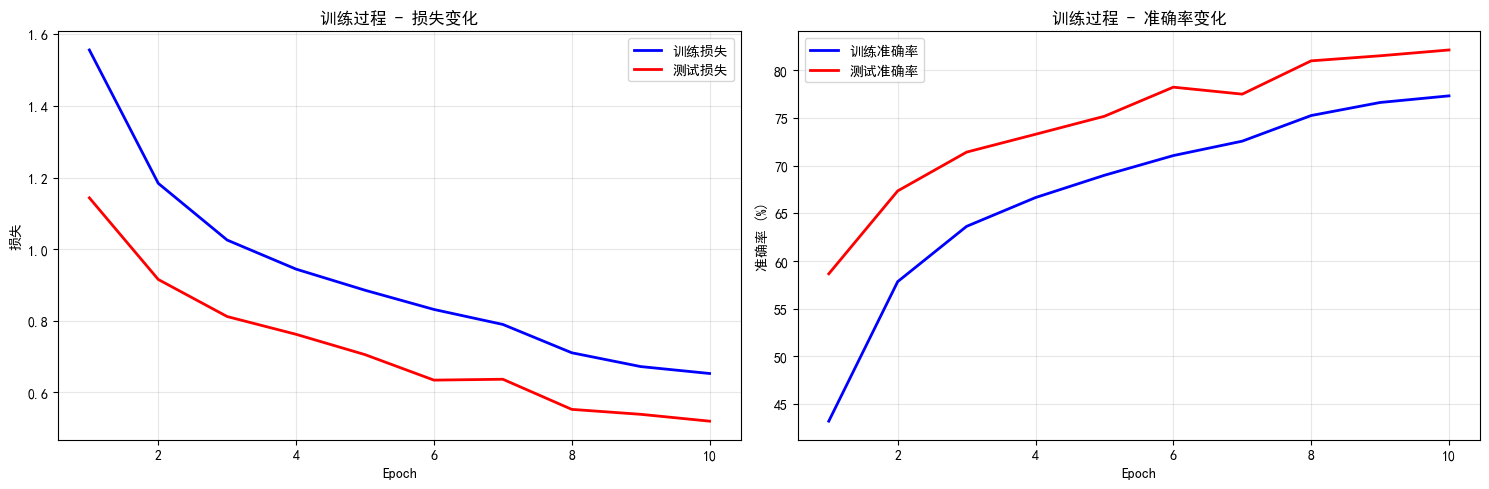

\n=== 训练结果总结 ===
初始训练准确率: 43.21%
最终训练准确率: 77.32%
初始测试准确率: 58.66%
最终测试准确率: 82.13%
准确率提升: 23.47%
\n✅ 模型已保存为 'cifar10_cnn_model.pth'


In [8]:
# 3.3.3 训练结果可视化
print("=== 训练结果可视化 ===")

# 绘制训练曲线
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 损失曲线
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, train_losses, 'b-', label='训练损失', linewidth=2)
ax1.plot(epochs, test_losses, 'r-', label='测试损失', linewidth=2)
ax1.set_title('训练过程 - 损失变化')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('损失')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 准确率曲线
ax2.plot(epochs, train_accuracies, 'b-', label='训练准确率', linewidth=2)
ax2.plot(epochs, test_accuracies, 'r-', label='测试准确率', linewidth=2)
ax2.set_title('训练过程 - 准确率变化')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('准确率 (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印最终结果总结
print("\\n=== 训练结果总结 ===")
print(f"初始训练准确率: {train_accuracies[0]:.2f}%")
print(f"最终训练准确率: {train_accuracies[-1]:.2f}%")
print(f"初始测试准确率: {test_accuracies[0]:.2f}%")
print(f"最终测试准确率: {test_accuracies[-1]:.2f}%")
print(f"准确率提升: {test_accuracies[-1] - test_accuracies[0]:.2f}%")

# 模型保存
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracies[-1],
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies
}, 'cifar10_cnn_model.pth')

print("\\n✅ 模型已保存为 'cifar10_cnn_model.pth'")


# 在下方说明实现思路